In [18]:
import pandas as pd

In [19]:
data = pd.read_csv('참외/datasets/from_public/seongju_only.csv')
# data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.head()

,거래년월일,거래량
0,2015-01-20,30
1,2015-01-31,40
2,2015-02-02,790
3,2015-02-04,2045
4,2015-02-05,810


In [20]:
#시계열 및 종속변수 이름 변경
data = data.rename(columns={"거래년월일":"ds","거래량":"y"})
data

,ds,y
0,2015-01-20,30
1,2015-01-31,40
2,2015-02-02,790
3,2015-02-04,2045
4,2015-02-05,810
...,...,...
1948,2022-12-24,840
1949,2022-12-26,720
1950,2022-12-28,130
1951,2022-12-29,340


In [21]:
data = data.fillna(0)

In [22]:
df=data[['ds','y']]

In [23]:
df.set_index('ds', inplace=True)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [8]:
# Set random seed to get the same result after each time running the code
tf.random.set_seed(1234)

In [25]:
# df_no_outliers = df_no_outliers.set_index('ds')
# # Assuming your data is stored in a variable named 'data'
df.index = pd.to_datetime(df.index)

In [26]:
df_resampled=df.resample('D').first().fillna(0)
# df_resampled.reset_index(inplace=True)


In [27]:
df_resampled

,y
ds,
2015-01-20,30.0
2015-01-21,0.0
2015-01-22,0.0
2015-01-23,0.0
2015-01-24,0.0
...,...
2022-12-27,0.0
2022-12-28,130.0
2022-12-29,340.0


In [28]:
#train test split
cutoff = "2022-01-01" #데이터 분할 기준
df_train = df_resampled[df_resampled.index<cutoff]
df_test = df_resampled[df_resampled.index>=cutoff]

In [13]:
df_train.tail(365)

,y
ds,
2021-01-01,0.0
2021-01-02,0.0
2021-01-03,0.0
2021-01-04,0.0
2021-01-05,920.0
...,...
2021-12-27,0.0
2021-12-28,820.0
2021-12-29,150.0


In [29]:
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(df_train)

train_scaled = scaler.transform(df_train)
test_scaled = scaler.transform(df_test)


In [30]:
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (2508, 30, 1)
y_train.shape:  (2508, 1)
X_test.shape:  (335, 30, 1)
y_test.shape:  (335, 1)


In [60]:
X_train.shape[2]

1

In [31]:
# Create GRU model
from tensorflow.keras.models import Sequential, model_from_json

def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
   
    return model
model_gru = create_gru(64)

# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(64)

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 200, validation_split = 0.2,
                    batch_size = 45, shuffle = False, callbacks = [early_stop])
    return history


history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

2023-04-07 16:52:10.478369: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-07 16:52:10.478401: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-07 16:52:10.478419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (centos-server-4): /proc/driver/nvidia/version does not exist
2023-04-07 16:52:10.478672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
45/45 [==============================] - 6s 50ms/step - loss: 0.0297 - val_loss: 0.0090
Epoch 2/200
45/45 [==============================] - 2s 35ms/step - loss: 0.0192 - val_loss: 0.0089
Epoch 3/200
45/45 [==============================] - 2s 35ms/step - loss: 0.0194 - val_loss: 0.0089
Epoch 4/200
45/45 [==============================] - 2s 35ms/step - loss: 0.0193 - val_loss: 0.0088
Epoch 5/200
45/45 [==============================] - 2s 35ms/step - loss: 0.0193 - val_loss: 0.0088
Epoch 6/200
45/45 [==============================] - 2s 35ms/step - loss: 0.0191 - val_loss: 0.0088
Epoch 7/200
45/45 [==============================] - 2s 35ms/step - loss: 0.0187 - val_loss: 0.0088
Epoch 8/200
45/45 [==============================] - 2s 35ms/step - loss: 0.0186 - val_loss: 0.0088
Epoch 9/200
45/45 [==============================] - 2s 35ms/step - loss: 0.0182 - val_loss: 0.0088
Epoch 10/200
45/45 [==============================] - 2s 35ms/step - loss: 0.0185 - val_loss: 0.0087

In [32]:
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 64)            12864     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


11/11 [==============================] - 1s 13ms/step
GRU:
Mean Absolute Error: 35327.8365
Root Mean Square Error: 67809.3348

Bidirectiona LSTM:
Mean Absolute Error: 63651.2806
Root Mean Square Error: 127870.5332



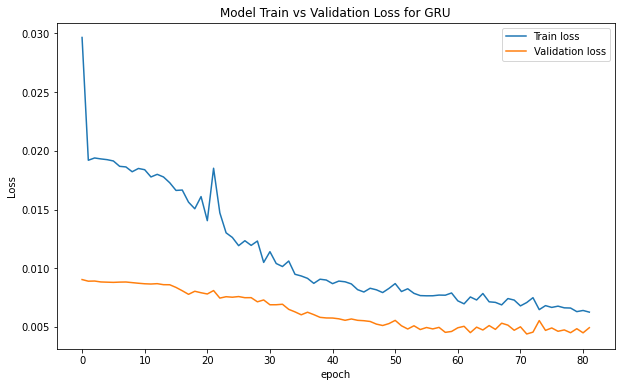

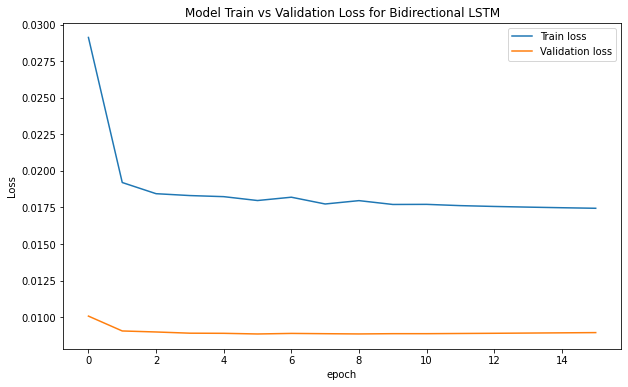

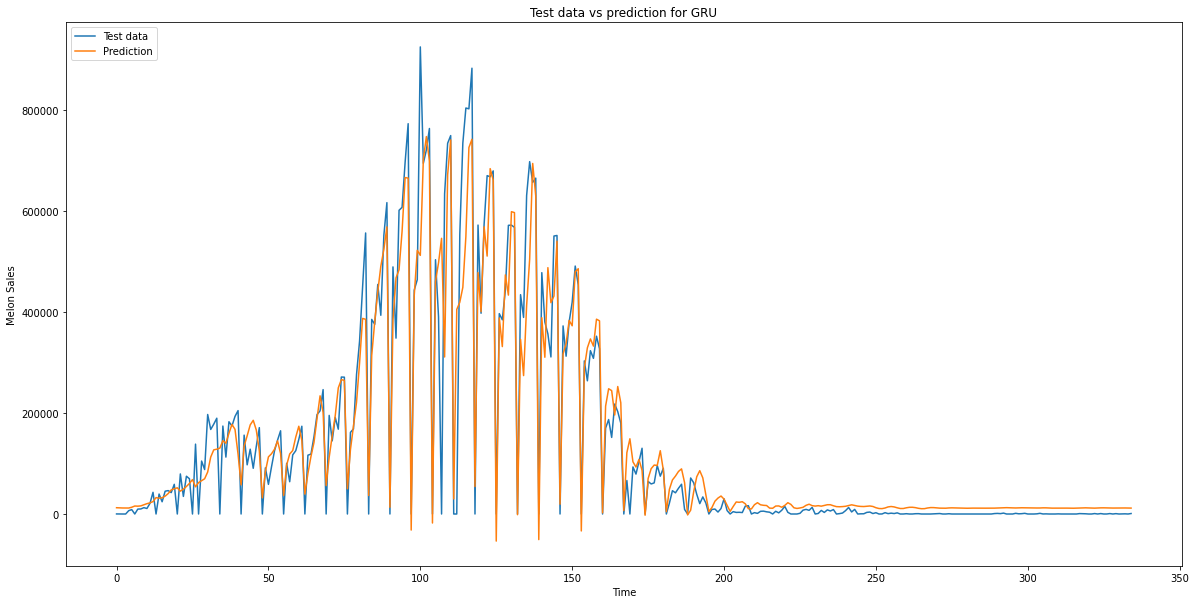

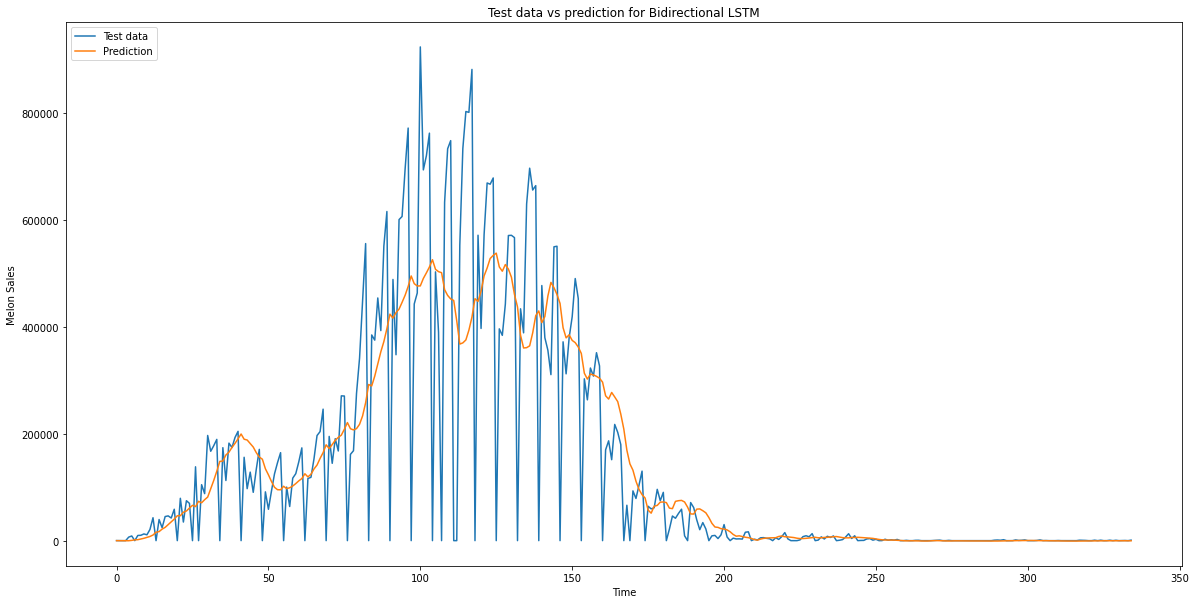

In [33]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.savefig('loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')

# Transform data back to original data space
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(20, 10))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Melon Sales')
       
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

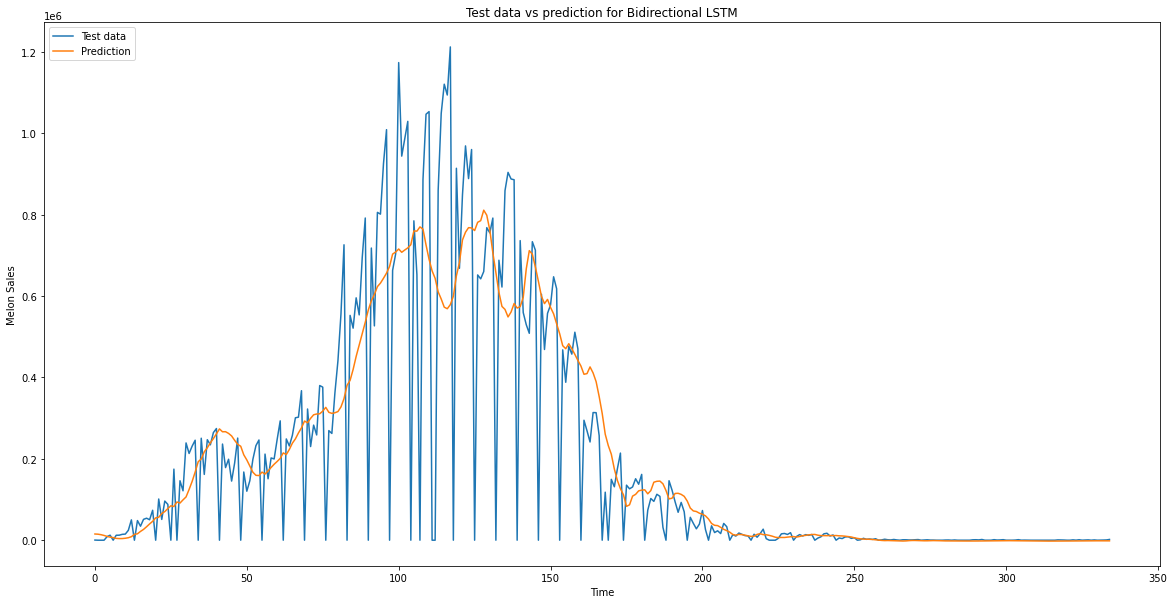

In [19]:
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

In [34]:
# import numpy as np

# def forecast(model, initial_input, num_steps, scaler):
#     input_sequence = initial_input.copy()
#     predictions = []

#     for i in range(num_steps):
#         # Reshape the input data to match the input shape of the GRU model
#         input_data = input_sequence.reshape(1, input_sequence.shape[0], input_sequence.shape[1])

#         # Predict the next value
#         prediction = model.predict(input_data)

#         # Append the prediction to the input sequence
#         input_sequence = np.concatenate((input_sequence[1:], prediction), axis=0)

#         # Add the prediction to the list of predictions
#         predictions.append(prediction[0])

#     # Convert the list of predictions to a numpy array
#     predictions = np.array(predictions)

#     # Reverse the preprocessing (e.g., scaling) applied to the data
#     if scaler is not None:
#         predictions = scaler.inverse_transform(predictions)

#     return predictions


In [38]:

import numpy as np

flattened_prediction_gru = np.ravel(prediction_gru)
flattened_y_test = np.ravel(y_test)

results_df = pd.DataFrame({'Prediction': flattened_prediction_gru, 'Actual': flattened_y_test})
results_df

,Prediction,Actual
0,12423.250000,130.0
1,12110.292969,0.0
2,11909.918945,0.0
3,11831.310547,0.0
4,11824.954102,6590.0
...,...,...
330,12051.689453,0.0
331,12102.016602,130.0
332,11937.270508,340.0
333,11794.059570,0.0


In [40]:
df_test.loc[30:,'Prediction'] = flattened_prediction_gru

In [45]:
df_test.fillna(0, inplace=True)

In [46]:
df_test['Prediction'] = df_test['Prediction'].apply(np.int64)

df_test['Prediction'] [df_test['Prediction'] <0]=0

In [47]:
import plotly.graph_objs as go

# Assume 'forecast' is your pandas DataFrame with columns 'y' and 'yhat1'
trace_y = go.Scatter(x=df_test.index, y=df_test['y'], mode='lines', name='y')
trace_yhat1 = go.Scatter(x=df_test.index, y=df_test['Prediction'], mode='lines', name='yhat1')

new = [trace_y, trace_yhat1]

layout = go.Layout(
    title='Forecast Plot',
    xaxis=dict(title='Index'),
    yaxis=dict(title='Value'),
    width=1000,
    height=500,
)

fig = go.Figure(data=new, layout=layout)
fig.show()

In [49]:
# Evaluate the ensemble model
# Evaluate the ensemble model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
ensemble_error_new = mean_absolute_error(df_test['y'], df_test['Prediction'])
rms_error_new = np.sqrt(mean_squared_error(df_test['y'], df_test['Prediction']))
print("Ensemble mean absolute error:", ensemble_error_new)
print("Ensemble root mean squared error:", rms_error_new)

Ensemble mean absolute error: 31916.12876712329
Ensemble root mean squared error: 64796.27242451782


In [37]:
prediction_gru.shape

(335, 1)

In [53]:
test_data = df_test.drop(['Prediction'], axis=1)

In [54]:
# Select 60 days of data from test data
new_data = test_data.iloc[100:160]
# Scale the input
scaled_data = scaler.transform(new_data)
# Reshape the input 
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        
    return np.array(Xs)

X_30= create_dataset(scaled_data,30)
print('X_30.shape: ', X_30.shape) 

X_30.shape:  (30, 30, 1)


1/1 [==============================] - 0s 31ms/step


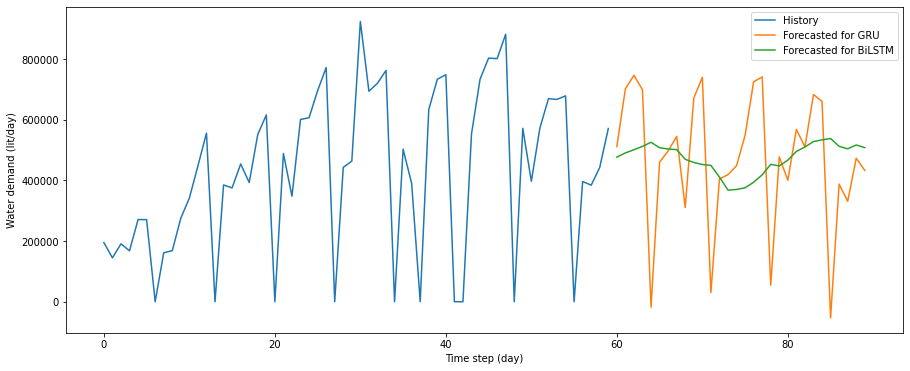

In [55]:
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
# Plot history and future
def plot_multi_step(history, prediction1, prediction2):
    
    plt.figure(figsize=(15, 6))
    
    range_history = len(history)
    range_future = list(range(range_history, range_history +
                        len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), 
             label='History')
    plt.plot(range_future, np.array(prediction1),
             label='Forecasted for GRU')
    plt.plot(range_future, np.array(prediction2),
             label='Forecasted for BiLSTM')
      
    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Water demand (lit/day)')
        
plot_multi_step(new_data, prediction_gru, prediction_bilstm)

In [58]:
prediction_gru.shape

(30, 1)